This below cell is directly copied from code base

In [26]:
# reading the data function

eps=1e-10

# reading the data
read.data <- function(file.name='./assessments_datasets/Task3A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  #docs <- data.frame(unlist(lapply(docs, function(x) x[2])))
  uid <- paste0("doc_", formatC(1:sample.size, width = 4, format = "d", flag = "0"))
  docs <- data.frame(doc_id = uid, text = unlist(lapply(docs, function(x) x[2])))
  
  library(tm)
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}
                                                        ## --- helper function ------------------------------------------------------------------ 
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
# Example: Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities \in [0,1]
#          To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function 
#          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
#          Then get the results by: exp(logSum(v))
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

Soft EM

In [27]:
##--- Soft E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM
# Student needs to modify this function if wants to make it Hard-EM 
#
soft.E.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  return (gamma)
}

##--- Soft M Step for Document Clustering  --------------------------------------------
soft.M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  epsilon = 0.001
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters

 
  # M step: Student needs to write this part for soft/hard EM
  # for each cluster 
  for (k in 1:K){
      # initialising the word proportions for each and all clusters
      word_count_all <- 0
      word_count <- c()
      # mixing component
      model$rho[k] <- sum(gamma[,k])/N
      # each document's cluster
      for (w_each in 1:W){  
          # each word
          word_count <- c(word_count,sum(gamma[,k]*counts[w_each,]))}
      for (w_all in 1:W){
          # all words
          word_count_all <- sum(gamma[,k]*counts[w_all,])+word_count_all}
      # hint: before you normalise a vector so that it sums to 1, first add a small number (eps) to all elements of the vector.
      # for example, suppose you have a vector [n1,n2,n3] and you want to normalise it to make it a probability distribution. 
      # you first need to add eps to elements [n1+eps,n2+eps,n3+eps], then divide the elements by (n1+n2+n3+ 3*eps) so that the vecotr sums to 1. 
      # this prevents NaN for vectors where all elements aer zero such as [0,0,0] because after adding eps you have [eps,eps,eps] which 
      # results in the uniform distribution after normalisation.
      # mormalising the numerator component of mu
      mu_numerator_normaliser <- ((word_count/word_count_all)+epsilon)
      # mormalising the denomenator component of mu
      mu_denomenator_normaliser <- (sum(word_count/word_count_all)+epsilon*W)
      model$mu[k,] <- mu_numerator_normaliser / mu_denomenator_normaliser
  }  
  # returning the model to be used in the convergence loop below
  return (model)
}

##--- Soft EM for Document Clustering --------------------------------------------
soft.EM <- function(counts, K=4, max.epoch=10, seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- soft.E.step(gamma, model, counts)
    # M Step
    model <- soft.M.step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

Hard EM 

In [28]:
##--- Hard E Step for Document Clustering  --------------------------------------------
hard.E.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
  
  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  # maximum probability clustering
  maximum.prob <- gamma==apply(gamma, 1, max) 
  # assinging highest probability points to cluster
  gamma[maximum.prob] <- 1 
  # removing lowest probability points from cluster
  gamma[!maximum.prob] <- 0
  return (gamma)
}


##--- Hard M Step for Document Clustering  --------------------------------------------
hard.M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  epsilon = 0.001
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters

 
  # M step: Student needs to write this part for soft/hard EM
  # for each cluster 
  for (k in 1:K){
      # initialising the word proportions for each and all clusters
      word_count_all <- 0
      word_count <- c()
      # mixing component
      model$rho[k] <- sum(gamma[,k])/N
      # each document's cluster
      for (w_each in 1:W){  
          # each word
          word_count <- c(word_count,sum(gamma[,k]*counts[w_each,]))}
      for (w_all in 1:W){
          # all words
          word_count_all <- sum(gamma[,k]*counts[w_all,])+word_count_all}
      # hint: before you normalise a vector so that it sums to 1, first add a small number (eps) to all elements of the vector.
      # for example, suppose you have a vector [n1,n2,n3] and you want to normalise it to make it a probability distribution. 
      # you first need to add eps to elements [n1+eps,n2+eps,n3+eps], then divide the elements by (n1+n2+n3+ 3*eps) so that the vecotr sums to 1. 
      # this prevents NaN for vectors where all elements aer zero such as [0,0,0] because after adding eps you have [eps,eps,eps] which 
      # results in the uniform distribution after normalisation.
      # mormalising the numerator component of mu
      mu_numerator_normaliser <- ((word_count/word_count_all)+epsilon)
      # mormalising the denomenator component of mu
      mu_denomenator_normaliser <- (sum(word_count/word_count_all)+epsilon*W)
      model$mu[k,] <- mu_numerator_normaliser / mu_denomenator_normaliser
  }  
  # returning the model to be used in the convergence loop below
  return (model)
}

##---Hard EM for Document Clustering --------------------------------------------
hard.EM <- function(counts, K=4, max.epoch=10, seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)
  
  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- hard.E.step(gamma, model, counts)
    # M Step
    model <- hard.M.step(gamma, model, counts)
    
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

In [29]:
##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

Soft EM Visualisation

[1] 886463.1
[1] 816675
[1] 812549.9
[1] 810241.5
[1] 809514.6
[1] 809223
[1] 809087.3
[1] 809015.8
[1] 808931.1
[1] 808864.5
[1] 808838.2
[1] 808806.2
[1] 808690.6
[1] 808528.8
[1] 808368.6
[1] 808337
[1] 808288.2
[1] 808187.3
[1] 808159.7
[1] 808135.2
[1] 808128.7
[1] 808124.4
[1] 808121.2
[1] 808115.4
[1] 808110.4
[1] 808109.5
[1] 808109.1
[1] 808108.9
[1] 808108.7
[1] 808108.5
[1] 808108.4
[1] 808108.4
[1] 808108.4
[1] 808108.5
[1] 808108.8
[1] 808109.3
[1] 808110
[1] 808110.2
[1] 808109.9
[1] 808109.2
[1] 808107.8
[1] 808105.6
[1] 808104.1
[1] 808103.4
[1] 808102.9
[1] 808102.6
[1] 808102.5
[1] 808102.3
[1] 808102.3
[1] 808102.3
[1] 808102.4
[1] 808102.4
[1] 808102.3
[1] 808101.9
[1] 808101.4
[1] 808100.8
[1] 808100.3
[1] 808099.8
[1] 808099.2
[1] 808098.4
[1] 808097.6
[1] 808097
[1] 808096.6
[1] 808096.1
[1] 808094.7
[1] 808091.4
[1] 808089.4
[1] 808089.1
[1] 808089
[1] 808089
[1] 808088.9
[1] 808088.9
[1] 808088.9
[1] 808088.9
[1] 808088.9
[1] 808088.9
[1] 808088.9
[1] 808088.9


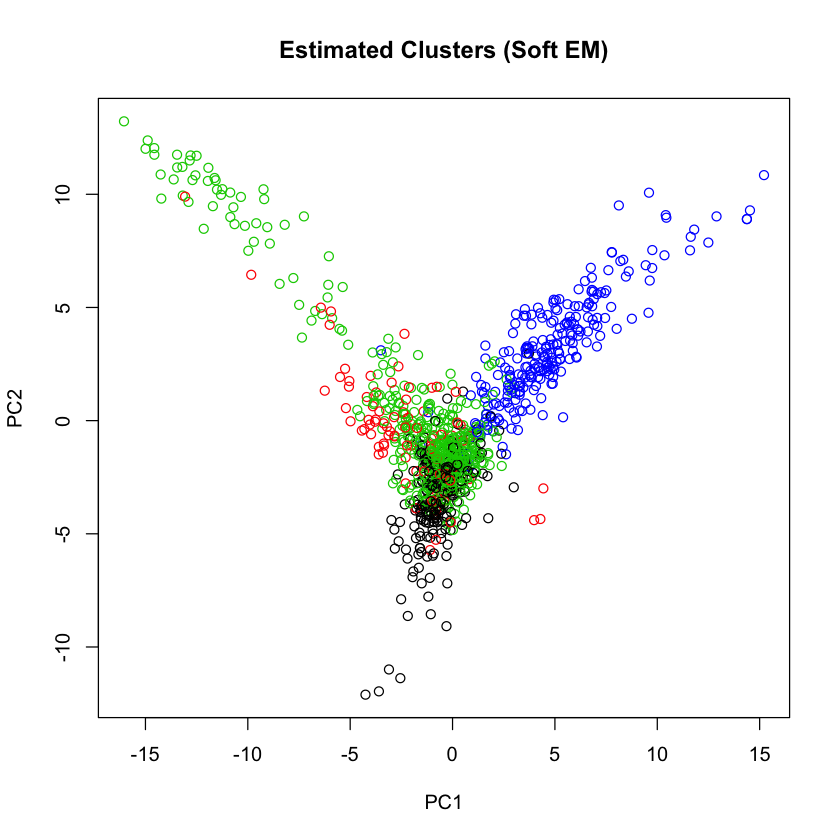

In [33]:
####### soft EM document visualising###############
### main body ##################################################################

# Reading documents 
## Note: sample.size=0 means all read all documents!
##(for develiopment and debugging use a smaller subset e.g., sample.size = 40)
#data <- read.data(file.name='./assessments_datasets/Task3A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)
data <- read.data(file.name='Task2A.txt', sample.size=1000, seed=1000, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        
# below is toy data if you want to work with
# counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)

# calling the EM algorithm on the data
res <- soft.EM(counts, K=4, max.epoch=100)   

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough
# pdf(file = "Soft_EM_Plot")
## visualize the estimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Soft EM)')
# dev.off()

Hard EM Visualisation

[1] 886463.1
[1] 816680.8
[1] 812593.2
[1] 810521
[1] 809706
[1] 809344.2
[1] 809162.2
[1] 809105.7
[1] 809079.6
[1] 809063.5
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1] 809057.8
[1]

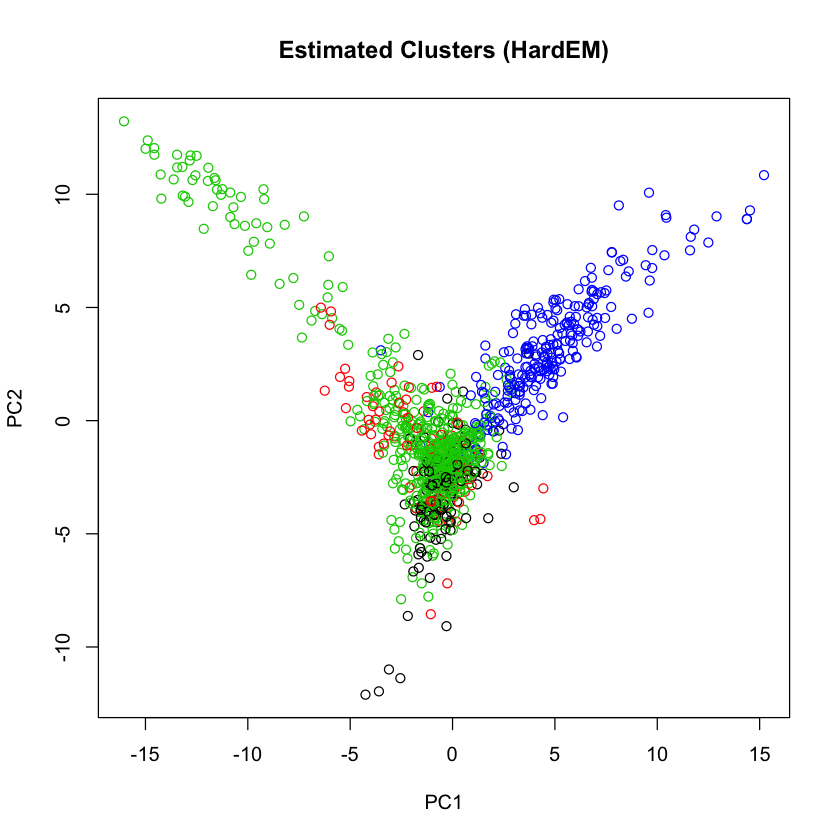

In [34]:
################### Hard EM document visualising###############
### main body ##################################################################

data <- read.data(file.name='Task2A.txt', sample.size=1000, seed=1000, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        
# below is toy data if you want to work with
# counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)

# calling the EM algorithm on the data
res <- hard.EM(counts, K=4, max.epoch=100)   

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

# pdf(file = "Hard_EM_Plot")
## visualize the estimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (HardEM)')
# dev.off()

Original CLuster

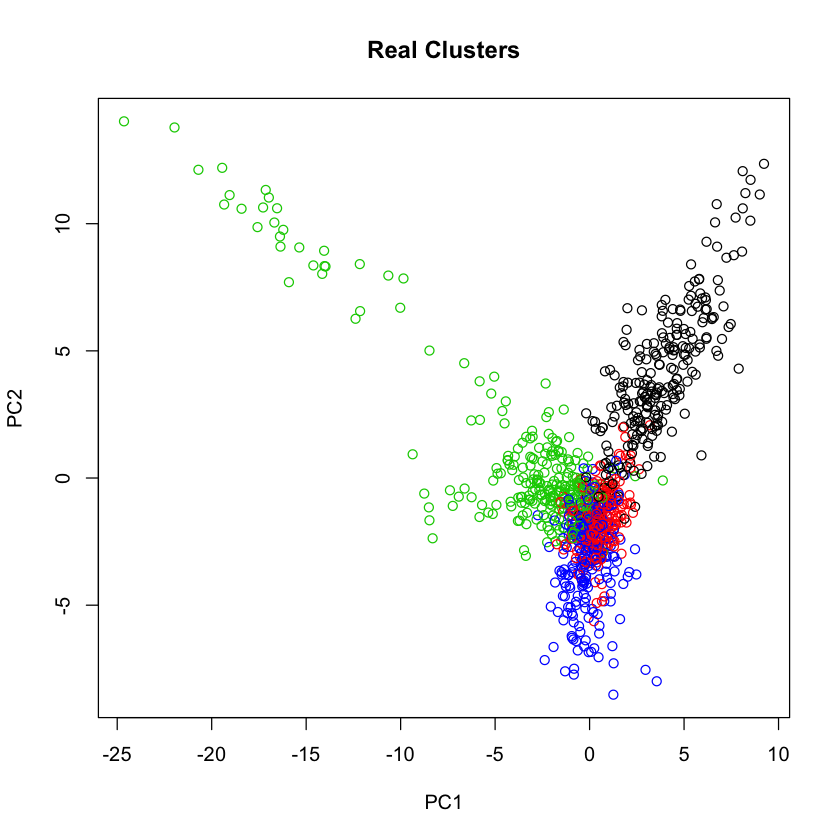

In [32]:
## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')

IV.
We can see a clear distinguishing between the labels for soft and hard EM. 
In the soft-EM, we can see that there is no overlapping of the labels and there is overlap in the hard-EM. This is so because each point is clustered to only one class (that is it being assigned to the maximum probability as we implemented in the code and algorithm). Hence, there is no mixing.
